# Implementing Fisher Information for Hopfield Networks
Here, we use sparse patterns in Hopfield Networks to demonstrate the overcoming of catastrophic forgetting.
This notebook is used for comparing results of Normal Hebbian Learning (with a diminished learning rate such that the average learning rate fits the other cases) with learning where a certain number of weights are kept constant. The weights that are supposed to be kept constant are picked in 5 different ways:
1. Highest Fisher information
2. Lowest Fisher information
3. Connections with largest absolute value of the weighs
4. Connections where absolute value of weights exceeds a certain value
5. Highest Fisher information calculated by 'Adapted Hebbian Learning Rule'

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# import time
# import random
# import math
import numpy as np
import copy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# from scipy.special import expit
# from scipy.misc import imresize
import sys
sys.path.append('../code')

In [3]:
from hopfieldNetwork import hopfieldNet
from solverFile import solverClass

## Define Hyperparameters
Can be changed and adapted.

In [47]:
ETA = 0.001 # learning rate
NTRAIN = 2000 # number of epochs
NUM_PATTERNS = 1000 # number of patterns created
SPARSITY = 0.1 # number of zeros: e.g. SPARSITY = 0.1 means 10% ones and 90% zeros
IMAGE_SIZE = 10 # the size of our created pattern will be (IMAGE_SIZE x IMAGE_SIZE)
eval_f = 1 # evaluation frequency (every eval_f-th iteration) NOTE: currently not implemented
TRIALS = 300 # number of trials over which the results will be averaged in order to get smooth results
less_changed_weight_value = 0.00 # the learning rate of weights which are considered important have a
                                 # learning rate of ETA * less_changed_weight_value
stored_patterns = 100 # number of patterns that are stored in the network before learning the new pattern
number_of_changed_values = 4750 # the number of weigths that are changed is 2*number_of_changed_values
                                # (The factor of 2 is because of the symmetry of the weight matrix)

# whether to run experiments with different learning rules
RUN_FL = False  # similar to FLT, I prefer the local version
RUN_FIH = False  # the experiment shows it's the same...
RUN_FLT = True

## Running a Pre-Test
Output should be:
The overall_error is:    0.0
If not, set SPARSITY = 0.1 (script is not optimized regarding generality yet ;) )

In [48]:
netFisher = hopfieldNet(IMAGE_SIZE, ETA, SPARSITY)
solver = solverClass()
patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, NUM_PATTERNS)
mean_value = SPARSITY
original_patterns = copy.deepcopy(patterns)
patterns = patterns - mean_value
p = np.zeros(shape=(IMAGE_SIZE**2, IMAGE_SIZE**2))
for i in range(int(stored_patterns)):
    p += np.outer(patterns[:,i], patterns[:,i])
    netFisher.append_pattern(patterns[:,i], NTRAIN)
w1 = p/70

#print(w1)

netFisher.set_weights(w1)
overall_error = 0
for i in range(int(stored_patterns)):
    netFisher.present_pattern(original_patterns[:,i])
    netFisher.step(100)
    output = netFisher.s
    error = np.sum(original_patterns[:,i]-output)**2
    overall_error += error
print('The overall_error is:   ', overall_error)

The overall_error is:    43.0


## Define Dice coefficent as measure of accuracy
As it can be seen, the results improve for all five cases, apart from the second one, where the results deteriorate.
The measure of correctness is the Dice-coefficient, which is 2*cardinality(overlap(A,B)) / (cardinality(A) + cardinality(B)), with A being the results and B being the target for cells to be a 1.
Hence, a Dice-coefficient of 1 means perfect memory, 0 means no memory.

In [49]:
def dice_coefficient(p1, p2):
    p = 2 * np.sum(np.floor(0.6*(p1 + p2)))
    n = np.sum(p1)+np.sum(p2)
    return p/n

## Script to prove that Hebbian way of calculating Fisher Information is equal to variance

In [50]:
solver = solverClass()
patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, NUM_PATTERNS)
netFisher = hopfieldNet(IMAGE_SIZE, ETA, SPARSITY)
original_patterns = copy.deepcopy(patterns)
patterns = patterns - SPARSITY

# Training the network (NOT NEEDED for curvature)
p = np.zeros(shape=(IMAGE_SIZE**2, IMAGE_SIZE**2))
overall_pattern = np.zeros(shape = np.shape(patterns[:,0]))

for i in range(int(stored_patterns)):
    p += np.outer(patterns[:,i], patterns[:,i])
    overall_pattern += (patterns[:,i]+SPARSITY)
    netFisher.append_pattern(patterns[:,i], NTRAIN)
netFisher.set_weights(p/70)

# Computing curvature
netFisher.calculate_fisher_information(patterns[:,0:stored_patterns])
wF = netFisher.curvature
netFisher.calculate_fisher_information_hebbian(patterns[:,0:stored_patterns], sparsity=SPARSITY)
wH = netFisher.curvature
wD = wF - wH
max_error = np.amax(np.abs(wD))
summed_error = np.sum(np.abs(wD))
print('Max error: ', max_error, "Summed error:", summed_error)
# plt.subplot(1,2,1)
# plt.imshow(wF)
# plt.subplot(1,2,2)
# plt.imshow(wH)


Max error:  3.375077994860476e-14 Summed error: 1.50430499279135e-11


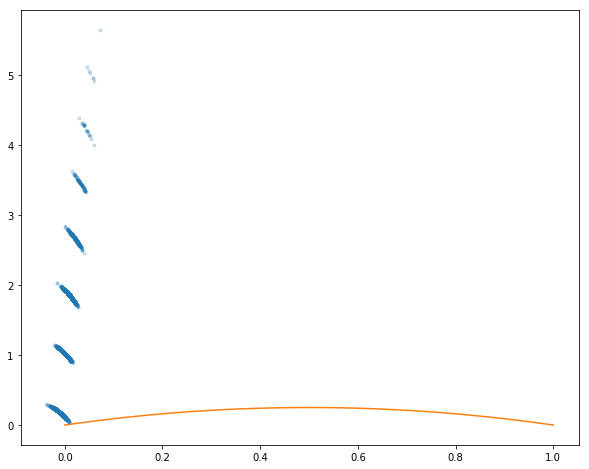

In [53]:
plt.plot(to_triangular(netFisher.w), to_triangular(wH), '.', alpha=.2)
x = np.linspace(0, 1, 100)
plt.plot(x, (x-x**2))
#plt.xlim([-.02, 0.1])
#plt.ylim([0, 10])

## Training Phase
Might take a couple of minutes. Output should look like:

Started Learning

Running trial  1  /  3 

Running trial  2  /  3

Running trial  3  /  3

Finished

In [ ]:
%run -i '../code/define_variables.py' #initializes all variables (mostly to zero)

In [12]:
def to_triangular(matrix):
    return matrix[np.triu_indices_from(matrix, 1)]

def from_triangular(size, arr, diagonal_value):
    matrix = np.zeros([size, size])
    matrix[np.triu_indices_from(matrix, 1)] = arr
    matrix += matrix.T
    np.fill_diagonal(matrix, diagonal_value)
    return matrix

In [ ]:
print('**Started Learning**')

for trial in range(0, TRIALS):
    if trial % eval_f == 0:
        print('Running trial ', trial+1, '/', TRIALS)
    solver = solverClass()
    patterns = solver.create_patterns(SPARSITY, IMAGE_SIZE, NUM_PATTERNS)
    netFisher = hopfieldNet(IMAGE_SIZE, ETA, SPARSITY)
    p = np.zeros(shape=(IMAGE_SIZE**2, IMAGE_SIZE**2))
    mean_value = SPARSITY
    original_patterns = copy.deepcopy(patterns)
    patterns = patterns - mean_value
    overall_pattern = np.zeros(shape = np.shape(patterns[:,0]))

    for i in range(int(stored_patterns)):
        p += np.outer(patterns[:,i], patterns[:,i])
        overall_pattern += (patterns[:,i]+mean_value)
        netFisher.append_pattern(patterns[:,i], NTRAIN)
    w1 = p/70

    
# ========== H ========== #
    wF = w1
    for epoch in range(NTRAIN):
        diminish_lr = 2 * number_of_changed_values / (IMAGE_SIZE**2)**2
        z = diminish_lr  * ETA * (np.outer(patterns[:,stored_patterns+1], patterns[:,stored_patterns+1]) - wF)
        perturbation_vector = z
        wF = wF + perturbation_vector
        summed_perturbed0 += np.mean(np.abs(perturbation_vector))
        netFisher.set_weights(wF)

        overall_error = np.zeros(NTRAIN)
        for i in range(int(stored_patterns)):
            netFisher.present_pattern(original_patterns[:,i])
            netFisher.step(100)
            output = netFisher.s
            error[epoch] = np.sum((original_patterns[:,i]-output)**2)
            error[epoch] = dice_coefficient(original_patterns[:,i], output)
            overall_error[epoch] += error[epoch]

        netFisher.present_pattern(original_patterns[:,stored_patterns+1])
        netFisher.step(100)
        output = netFisher.s
        error[epoch] = np.sum((original_patterns[:,stored_patterns+1]-output)**2)
        error[epoch] = dice_coefficient(original_patterns[:,stored_patterns+1], output)

        complete_error_mean[trial, epoch] = overall_error[epoch]/stored_patterns
        complete_error_new_pattern[trial, epoch] = error[epoch]
        
    wH_final = netFisher.w
    
# ========= FL ========= #
    if RUN_FL:
        #Now disturbing the weights
        wF = w1
        for epoch in range(NTRAIN):
            z = ETA * (np.outer(patterns[:,stored_patterns+1], patterns[:,stored_patterns+1]) - wF)
            netFisher.curvature = np.abs(w1)  # not an actual curvature
            weight_perturbation = less_changed_weight_value*np.ones(shape = np.shape(w1))
            np.fill_diagonal(weight_perturbation, 1)
            copied_curvature = copy.deepcopy(netFisher.curvature)  # not an actual curvature
            np.fill_diagonal(copied_curvature, 1000) #setting it to a very high value such that the diagonal is not touched
            
            copied_curvature_tri = to_triangular(copied_curvature) # Martino
            weight_perturbation_tri = to_triangular(weight_perturbation)  # Martino
            small_idx = np.argsort(copied_curvature_tri, axis=None)
            weight_perturbation_tri[small_idx[:number_of_changed_values]] = 1
            copied_curvature_tri[small_idx[:number_of_changed_values]] = 2000
            weight_perturbation_v2 = from_triangular(IMAGE_SIZE**2, weight_perturbation_tri, 1)
            copied_curvature_v2 = from_triangular(IMAGE_SIZE**2, copied_curvature_tri, 1000)

#             for i in range(number_of_changed_values):
#                 y_ind_current, x_ind_current = np.unravel_index(copied_curvature.argmin(), copied_curvature.shape)
#                 weight_perturbation[y_ind_current, x_ind_current] = 1
#                 weight_perturbation[x_ind_current, y_ind_current] = 1
#                 copied_curvature[y_ind_current, x_ind_current] = 2000
#                 copied_curvature[x_ind_current, y_ind_current] = 2000
#             print(np.sum(np.abs(weight_perturbation - weight_perturbation_v2)))
            weight_perturbation = weight_perturbation_v2
            copied_curvature = copied_curvature_v2


            if (epoch % 100) == 0:
                print('The number of perturbed weights is (case 1):   ', np.sum(weight_perturbation))

            xyz = np.zeros(np.shape(w1))
            xyz[weight_perturbation == 1] = w1[weight_perturbation == 1]
            mean_w1_considered2 += np.mean(np.abs(xyz))
            perturbation_vector = weight_perturbation * z
            wF = wF + perturbation_vector
            summed_perturbed2 += np.mean(np.abs(perturbation_vector))
            netFisher.set_weights(wF)

            overall_errorFL = np.zeros(NTRAIN)
            for i in range(int(stored_patterns)):
                netFisher.present_pattern(original_patterns[:,i])
                netFisher.step(100)
                output = netFisher.s
                error[epoch] = np.sum((original_patterns[:,i]-output)**2)
                error[epoch] = dice_coefficient(original_patterns[:,i], output)
                overall_errorFL[epoch] += error[epoch]

            netFisher.present_pattern(original_patterns[:,stored_patterns+1])
            netFisher.step(100)
            output = netFisher.s
            error[epoch] = np.sum((original_patterns[:,stored_patterns+1]-output)**2)
            error[epoch] = dice_coefficient(original_patterns[:,stored_patterns+1], output)

            complete_error_meanFL[trial, epoch] = overall_errorFL[epoch]/stored_patterns
            complete_error_new_patternFL[trial, epoch] = error[epoch]

            if epoch == 0:
                x = np.abs(netFisher.w).flatten()
                netFisher.curvature = np.abs(w1)
                y = netFisher.curvature.flatten()
                plt.figure(figsize=(5,5))
                plt.plot(x,y, 'x')
                plt.xlabel('abs(w)')
                plt.ylabel('FisherInf')
                plt.show()

        wFL_final = netFisher.w

# ======== FLT ========= #
# Now disturbing the weights
    if RUN_FLT:
        wF = w1
        for epoch in range(NTRAIN):
            z = ETA * (np.outer(patterns[:,stored_patterns+1], patterns[:,stored_patterns+1]) - wF)
            netFisher.curvature = np.abs(w1)
            weight_perturbation = less_changed_weight_value*np.ones(shape = np.shape(w1))
            np.fill_diagonal(weight_perturbation, 1)

            weight_perturbation[np.abs(w1) < 0.008] = 1
            np.fill_diagonal(weight_perturbation, 1)
            if (epoch % 100) == 0:
                print('The number of perturbed weights is (case 2):   ', np.sum(weight_perturbation))

            xyz = np.zeros(np.shape(w1))
            xyz[weight_perturbation == 1] = w1[weight_perturbation == 1]
            mean_w1_considered2 += np.mean(np.abs(xyz))
            perturbation_vector = weight_perturbation * z
            wF = wF + perturbation_vector
            summed_perturbed2 += np.mean(np.abs(perturbation_vector))
            netFisher.set_weights(wF)

            overall_errorFLT = np.zeros(NTRAIN)
            for i in range(int(stored_patterns)):
                netFisher.present_pattern(original_patterns[:,i])
                netFisher.step(100)
                output = netFisher.s
                error[epoch] = np.sum((original_patterns[:,i]-output)**2)
                error[epoch] = dice_coefficient(original_patterns[:,i], output)
                overall_errorFLT[epoch] += error[epoch]

            netFisher.present_pattern(original_patterns[:,stored_patterns+1])
            netFisher.step(100)
            output = netFisher.s
            error[epoch] = np.sum((original_patterns[:,stored_patterns+1]-output)**2)
            error[epoch] = dice_coefficient(original_patterns[:,stored_patterns+1], output)

            complete_error_meanFLT[trial, epoch] = overall_errorFLT[epoch]/stored_patterns
            complete_error_new_patternFLT[trial, epoch] = error[epoch]

            #if epoch == (NTRAIN-1):
            #    x = np.abs(netFisher.w).flatten()
            #    netFisher.curvature = np.abs(w1)
            #    y = netFisher.curvature.flatten()
            #    plt.figure(figsize=(5,5))
            #    plt.plot(x,y, 'x')
            #    plt.xlabel('abs(w)')
            #    plt.ylabel('FisherInf')
            #    plt.show()

        wFLT_final = netFisher.w
    

# ======== FI ======== #
# Now disturbing the weights
    wF = w1
    for epoch in range(NTRAIN):
        z = ETA * (np.outer(patterns[:,stored_patterns+1], patterns[:,stored_patterns+1]) - wF)
        #netFisher.calculate_fisher_information(patterns[:,0:stored_patterns+1])
        netFisher.calculate_fisher_information(patterns[:,0:stored_patterns])
        weight_perturbation = less_changed_weight_value*np.ones(shape = np.shape(w1))
        np.fill_diagonal(weight_perturbation, 1)
        copied_curvature = copy.deepcopy(netFisher.curvature)
        np.fill_diagonal(copied_curvature, 1000) # setting it to a very high value such that the diagonal is not touched
        
        copied_curvature_tri = to_triangular(copied_curvature) # Martino
        weight_perturbation_tri = to_triangular(weight_perturbation)  # Martino
        small_idx = np.argsort(copied_curvature_tri, axis=None)
        weight_perturbation_tri[small_idx[:number_of_changed_values]] = 1
        copied_curvature_tri[small_idx[:number_of_changed_values]] = 2000
        weight_perturbation_v2 = from_triangular(IMAGE_SIZE**2, weight_perturbation_tri, 1)
        copied_curvature_v2 = from_triangular(IMAGE_SIZE**2, copied_curvature_tri, 1000)
            
#         for i in range(number_of_changed_values):
#             y_ind_current, x_ind_current = np.unravel_index(copied_curvature.argmin(), copied_curvature.shape)
#             weight_perturbation[y_ind_current, x_ind_current] = 1
#             weight_perturbation[x_ind_current, y_ind_current] = 1
#             copied_curvature[y_ind_current, x_ind_current] = 2000
#             copied_curvature[x_ind_current, y_ind_current] = 2000
            
#         print(np.sum(np.abs(weight_perturbation - weight_perturbation_v2)))
        weight_perturbation = weight_perturbation_v2
        copied_curvature = copied_curvature_v2


        xyz = np.zeros(np.shape(w1))
        xyz[weight_perturbation == 1] = w1[weight_perturbation == 1]
        mean_w1_considered2 += np.mean(np.abs(xyz))
        perturbation_vector = weight_perturbation * z
        wF = wF + perturbation_vector
        summed_perturbed2 += np.mean(np.abs(perturbation_vector))
        netFisher.set_weights(wF)

        overall_errorFI = np.zeros(NTRAIN)
        for i in range(int(stored_patterns)):
            netFisher.present_pattern(original_patterns[:,i])
            netFisher.step(100)
            output = netFisher.s
            error[epoch] = np.sum((original_patterns[:,i]-output)**2)
            error[epoch] = dice_coefficient(original_patterns[:,i], output)
            overall_errorFI[epoch] += error[epoch]

        netFisher.present_pattern(original_patterns[:,stored_patterns+1])
        netFisher.step(100)
        output = netFisher.s
        error[epoch] = np.sum((original_patterns[:,stored_patterns+1]-output)**2)
        error[epoch] = dice_coefficient(original_patterns[:,stored_patterns+1], output)

        complete_error_meanFI[trial, epoch] = overall_errorFI[epoch]/stored_patterns
        complete_error_new_patternFI[trial, epoch] = error[epoch]

        #if epoch == (NTRAIN-1):
        #    x = np.abs(netFisher.w).flatten()
        #    netFisher.calculate_fisher_information(patterns[:,0:stored_patterns+1])
        #    y = netFisher.curvature.flatten()
        #    plt.figure(figsize=(5,5))
        #    plt.plot(x,y, 'x')
        #    plt.xlabel('abs(w)')
        #    plt.ylabel('FisherInf')
        #    plt.show()

# ======== FIH ========= #    
# Now disturbing the weights using hebbian way for fisher information
    if RUN_FIH:
        wF = w1
        for epoch in range(NTRAIN):
            z = ETA * (np.outer(patterns[:,stored_patterns+1], patterns[:,stored_patterns+1]) - wF)
            #netFisher.calculate_fisher_information(patterns[:,0:stored_patterns+1])
            netFisher.calculate_fisher_information_hebbian(patterns[:,0:stored_patterns])
            weight_perturbation = less_changed_weight_value*np.ones(shape = np.shape(w1))
            np.fill_diagonal(weight_perturbation, 1)
            copied_curvature = copy.deepcopy(netFisher.curvature)
            np.fill_diagonal(copied_curvature, 1000) #setting it to a very high value such that the diagonal is not touched
            
            copied_curvature_tri = to_triangular(copied_curvature) # Martino
            weight_perturbation_tri = to_triangular(weight_perturbation)  # Martino
            small_idx = np.argsort(copied_curvature_tri, axis=None)
            weight_perturbation_tri[small_idx[:number_of_changed_values]] = 1
            copied_curvature_tri[small_idx[:number_of_changed_values]] = 2000
            weight_perturbation_v2 = from_triangular(IMAGE_SIZE**2, weight_perturbation_tri, 1)
            copied_curvature_v2 = from_triangular(IMAGE_SIZE**2, copied_curvature_tri, 1000)
            
#             for i in range(number_of_changed_values):
#                 y_ind_current, x_ind_current = np.unravel_index(copied_curvature.argmin(), copied_curvature.shape)
#                 weight_perturbation[y_ind_current, x_ind_current] = 1
#                 weight_perturbation[x_ind_current, y_ind_current] = 1
#                 copied_curvature[y_ind_current, x_ind_current] = 2000
#                 copied_curvature[x_ind_current, y_ind_current] = 2000
#             print(np.sum(np.abs(weight_perturbation - weight_perturbation_v2)))
            weight_perturbation = weight_perturbation_v2
            copied_curvature = copied_curvature_v2


            xyz = np.zeros(np.shape(w1))
            xyz[weight_perturbation == 1] = w1[weight_perturbation == 1]
            mean_w1_considered2 += np.mean(np.abs(xyz))
            perturbation_vector = weight_perturbation * z
            wF = wF + perturbation_vector
            summed_perturbed2 += np.mean(np.abs(perturbation_vector))
            netFisher.set_weights(wF)

            overall_errorFIH = np.zeros(NTRAIN)
            for i in range(int(stored_patterns)):
                netFisher.present_pattern(original_patterns[:,i])
                netFisher.step(100)
                output = netFisher.s
                error[epoch] = np.sum((original_patterns[:,i]-output)**2)
                error[epoch] = dice_coefficient(original_patterns[:,i], output)
                overall_errorFIH[epoch] += error[epoch]

            netFisher.present_pattern(original_patterns[:,stored_patterns+1])
            netFisher.step(100)
            output = netFisher.s
            error[epoch] = np.sum((original_patterns[:,stored_patterns+1]-output)**2)
            error[epoch] = dice_coefficient(original_patterns[:,stored_patterns+1], output)

            complete_error_meanFIH[trial, epoch] = overall_errorFIH[epoch]/stored_patterns
            complete_error_new_patternFIH[trial, epoch] = error[epoch]

            #if epoch == (NTRAIN-1):
            #    x = np.abs(netFisher.w).flatten()
            #    netFisher.calculate_fisher_information(patterns[:,0:stored_patterns+1])
            #    y = netFisher.curvature.flatten()
            #    plt.figure(figsize=(5,5))
            #    plt.plot(x,y, 'x')
            #    plt.xlabel('abs(w)')
            #    plt.ylabel('FisherInf')
            #    plt.show()

        wFIH_final = netFisher.w
print('**Finished**')

In [ ]:
savedict = {
    'trad_80_O': complete_error_mean,
    'trad_80_N': complete_error_new_pattern,
    'FI_O': complete_error_meanFI,
    'FI_N': complete_error_new_patternFI }

keys = ['trad_80_O', 'trad_80_N'] 

if RUN_FL:
    savedict['FL_O'] = complete_error_meanFL
    savedict['FL_N'] = complete_error_new_patternFL
    keys += ['FL_O', 'FL_N']
if RUN_FLT:
    savedict['FLT_O'] = complete_error_meanFLT
    savedict['FLT_N'] = complete_error_new_patternFLT
    keys += ['FLT_O', 'FLT_N']
keys += ['FI_O', 'FI_N']
if RUN_FIH:
    savedict['FIH_O'] = complete_error_meanFIH
    savedict['FIH_N'] = complete_error_new_patternFIH
    keys += ['FIH_O', 'FIH_N']

In [ ]:
filename = "Complete_errors2.npz"
np.savez(filename, **savedict)

# Display results
### Which could be loaded independently of the code above

In [ ]:
filename = "../prova_Complete_errors_stored5_size10.npz"
savedict = np.load(filename)

In [ ]:
def plot_stuff(what, label):
    center = np.median(what, axis=0)
    edges = np.percentile(what, [25, 75], axis=0)
    plt.plot(center, label=label)
    plt.fill_between(np.arange(len(center)), *edges, alpha=.3)
    plt.ylabel('Pixel Error %')
    plt.ylim([0, 1.1])
    plt.legend(loc='upper right')

In [ ]:
ndatasets = len(savedict.keys())
for i, k in enumerate(savedict.keys()):
    plt.subplot(ndatasets//2, 2, i+1)
    plot_stuff(savedict[k], label=k)
    
plt.xlabel("n. Iterations")

In [ ]:
def plot_stuff_together(what, label, axisn):
    plt.subplot(1, 2, axisn)
    center = np.median(what, axis=0)
    edges = np.percentile(what, [25, 75], axis=0)
    l = plt.plot(center, label=label, linewidth=2.5)
    c = l[0].get_color()
    plt.fill_between(np.arange(len(center)), *edges, alpha=.15, color=c)
    plt.plot(edges.T, color=c, alpha=.2)
    plt.ylabel('Pixel Error %')
    plt.ylim([0, 1.1])
    plt.legend(loc='lower right')
    plt.xlim([-1, 2000])

In [ ]:
plt.figure(figsize = (20,8))

for k in savedict.keys():
    axisn = 2 if k[-1] == 'N' else 1
    plot_stuff_together(savedict[k], label=k, axisn=axisn)
    
plt.subplot(122)
plt.title('New pattern',fontweight='bold', fontsize=20)
plt.xlabel('Iteration')
plt.ylabel('Dice Coefficient')

plt.subplot(121)
plt.title('Old pattern',fontweight='bold', fontsize=20)
plt.xlabel('Iteration')
plt.ylabel('Dice Coefficient')